# SINDy-SHRED: Toy Data Example

This notebook demonstrates SINDy-SHRED on a synthetic toy dataset using the `SINDyShred` class. The class handles data preprocessing, model training, and post-hoc SINDy discovery automatically.

## Overview

**SHRED** (SHallow REcurrent Decoder) models combine a recurrent layer (GRU) with a shallow decoder network to reconstruct high-dimensional spatio-temporal fields from sensor measurements.

**SINDy-SHRED** extends this by integrating Sparse Identification of Nonlinear Dynamics (SINDy) to learn interpretable governing equations:

$$\dot{z} = \Theta(z) \xi$$

## Toy Data

The synthetic data combines two dynamical systems:

1. **FitzHugh-Nagumo Model** (slow dynamics):
   $$\dot{v} = v - \frac{1}{3}v^3 - w + I_{ext}$$
   $$\dot{w} = \frac{1}{\tau_1}(v + a - bw)$$

2. **Unforced Duffing Oscillator** (fast dynamics):
   $$\dot{p} = q$$
   $$\dot{q} = -\frac{1}{\tau_2}(p + \epsilon p^3)$$

These are combined via orthogonal mixing to create multi-scale spatio-temporal data.

## Notebook Structure

1. Setup and Imports
2. Data Generation
3. Model Configuration and Training
4. SINDy Discovery
5. Evaluation

## 1. Setup and Imports

In [1]:
import copy
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import torch
from scipy.integrate import solve_ivp

# Local modules
from sindy_shred import SINDyShred
import plotting

warnings.filterwarnings("ignore")

/home/mars/sindy-shred/sindyshred/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


### Device and Seed Configuration

In [2]:
# Device selection
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

Using device: cuda


### Plotting Configuration

In [3]:
sns.set_context("paper")
sns.set_style("whitegrid")

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

## 2. Data Generation

Generate synthetic spatio-temporal data from the FitzHugh-Nagumo and Duffing oscillator systems.

### Define Dynamical Systems

In [4]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model (slow dynamics).
    
    Parameters
    ----------
    t : float
        Time (unused, for ODE solver interface).
    x : array-like
        State vector [v, w].
    tau : float
        Time constant.
    a, b : float
        Model parameters.
    Iext : float
        External input current.
        
    Returns
    -------
    dx : array-like
        Time derivatives [dv/dt, dw/dt].
    """
    v, w = x
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    return np.array([vdot, wdot])


def rhs_UFD(t, y, eta, epsilon, tau):
    """Unforced Duffing Oscillator (fast dynamics).
    
    Parameters
    ----------
    t : float
        Time (unused, for ODE solver interface).
    y : array-like
        State vector [p, q].
    eta : float
        Damping coefficient.
    epsilon : float
        Nonlinearity strength.
    tau : float
        Time constant.
        
    Returns
    -------
    dy : array-like
        Time derivatives [dp/dt, dq/dt].
    """
    p, q = y
    pdot = q
    qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
    return np.array([pdot, qdot])

### Generate Data

In [5]:
# Time integration parameters
T = 64
dt = 0.0001 * 8
t_solution = np.arange(0, T, dt)

# FitzHugh-Nagumo parameters (slow mode, tau1=2)
x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

# Duffing oscillator parameters (fast mode, tau2=0.2)
y0 = np.array([0, 1])
eta = 0
epsilon = 1
tau2 = 0.2

# Solve the ODEs
solution_fn = solve_ivp(
    rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext)
)
solution_ufd = solve_ivp(
    rhs_UFD, [0, T], y0, t_eval=t_solution, args=(eta, epsilon, tau2)
)

print(f"FitzHugh-Nagumo solution shape: {solution_fn.y.shape}")
print(f"Duffing oscillator solution shape: {solution_ufd.y.shape}")

FitzHugh-Nagumo solution shape: (2, 80000)
Duffing oscillator solution shape: (2, 80000)


In [6]:
# Create mixed spatio-temporal data
seed = 1
num_space_dims = 10

# Tile the solutions to create spatial replicates
uv_tiled = np.hstack([
    np.tile(solution_fn.y.T, num_space_dims),
    np.tile(solution_ufd.y.T, num_space_dims),
])

# Subsample for computational efficiency
substep = 50
uv_tiled = uv_tiled[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution
dt_data = time[1] - time[0]

# Get dimensions
n_space_dims = uv_tiled.shape[1]
n_time = uv_tiled.shape[0]

# Apply orthogonal mixing
Q = scipy.stats.ortho_group.rvs(n_space_dims, random_state=seed)
Q = Q[0:n_space_dims, :]
x = uv_tiled @ Q

# Final data matrix (time x space)
data_original = x.T

# Extract slow and fast mode components for comparison
slow_modes = uv_tiled[:, 0:n_space_dims // 2] @ Q[0:n_space_dims // 2, :]
fast_modes = uv_tiled[:, n_space_dims // 2:] @ Q[n_space_dims // 2:, :]

print(f"Data shape (space x time): {data_original.shape}")
print(f"Time step: {dt_data:.6f}")
print(f"Number of time samples: {n_time}")
print(f"Spatial dimension: {n_space_dims}")

Data shape (space x time): (40, 1600)
Time step: 0.040000
Number of time samples: 1600
Spatial dimension: 40


### Visualize Generated Data

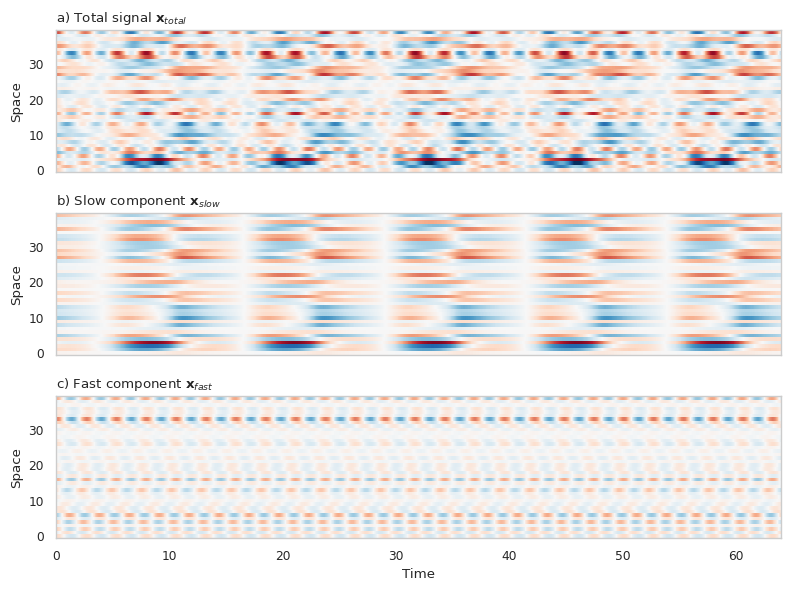

In [7]:
space_dim = np.arange(n_space_dims)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(time, space_dim, data_original, **pcolor_kwargs)
ax.set_title(r"a) Total signal $\mathbf{x}_{total}$", loc="left")
ax.set_ylabel("Space")

ax = axes[1]
ax.pcolormesh(time, space_dim, slow_modes.T, **pcolor_kwargs)
ax.set_title(r"b) Slow component $\mathbf{x}_{slow}$", loc="left")
ax.set_ylabel("Space")

ax = axes[2]
ax.pcolormesh(time, space_dim, fast_modes.T, **pcolor_kwargs)
ax.set_title(r"c) Fast component $\mathbf{x}_{fast}$", loc="left")
ax.set_ylabel("Space")
ax.set_xlabel("Time")

fig.tight_layout()
plt.show()

## 3. Model Configuration and Training

Configure the SINDy-SHRED model using the `SINDyShred` class.

### Data Configuration

In [8]:
# Sensor configuration (fixed for reproducibility)
sensor_locations = np.array([10, 28, 14, 11, 23, 27])
num_sensors = len(sensor_locations)

# Model hyperparameters
latent_dim = 4
poly_order = 1
include_sine = False
include_constant = True

# Data split configuration
lags = 120
train_length = 750 // 4
validate_length = 0

# Prepare data (transpose to time x space, subsample)
load_X = copy.deepcopy(data_original)
load_X = load_X.T[::4]  # Subsample
dt = dt_data * 4
lags = lags // 4

# SINDy threshold
threshold = 0.0

print(f"Data shape after preprocessing: {load_X.shape}")
print(f"Number of sensors: {num_sensors}")
print(f"Latent dimension: {latent_dim}")
print(f"Trajectory length (lags): {lags}")
print(f"Training length: {train_length}")
print(f"Time step: {dt:.6f}")

Data shape after preprocessing: (400, 40)
Number of sensors: 6
Latent dimension: 4
Trajectory length (lags): 30
Training length: 187
Time step: 0.160000


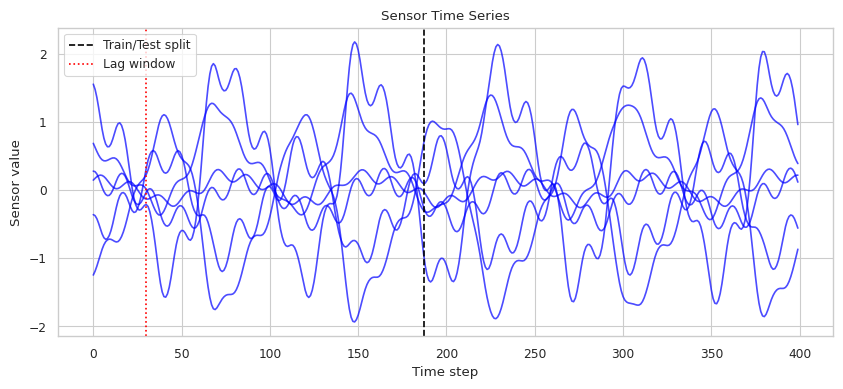

In [9]:
# Visualize sensor time series
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(load_X[:, sensor_locations], color='b', alpha=0.7)
ax.axvline(train_length, color='k', linestyle='--', label='Train/Test split')
ax.axvline(lags, color='r', linestyle=':', label='Lag window')
ax.set_xlabel('Time step')
ax.set_ylabel('Sensor value')
ax.set_title('Sensor Time Series')
ax.legend()
plt.show()

### Initialize and Train Model

The `SINDyShred` class handles data preprocessing and model training.

In [10]:
# Initialize the model
model = SINDyShred(
    latent_dim=latent_dim, 
    poly_order=poly_order, 
    verbose=True
)

# Fit the model
model.fit(
    num_sensors,
    dt,
    load_X,
    lags,
    train_length,
    validate_length,
    sensor_locations
)

1 : tensor(0.2841, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0368, device='cuda:

## 4. SINDy Discovery

Discover sparse governing equations from the learned latent space.

SINDy-derived dynamical equation:

(x0)' = -0.261 1 + 2.698 x0 + 6.229 x1 + 5.042 x2 + -1.658 x3
(x1)' = 0.062 1 + -0.559 x0 + -1.831 x1 + -0.871 x2 + 1.288 x3
(x2)' = -0.005 1 + -0.975 x0 + -0.220 x1 + -0.958 x2 + -1.289 x3
(x3)' = -0.129 1 + 1.101 x0 + 1.772 x1 + 2.359 x2 + 0.138 x3


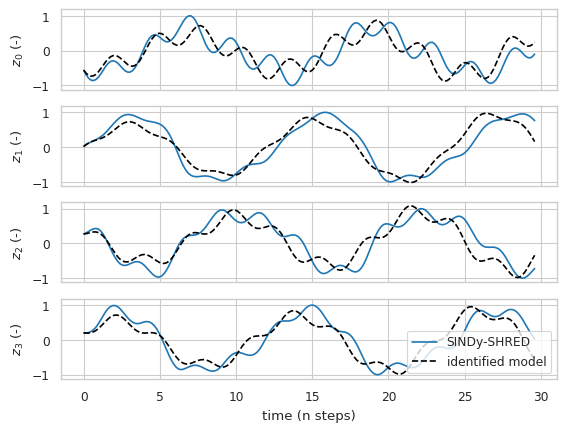

<Figure size 640x480 with 0 Axes>

In [11]:
# Perform SINDy identification
model.sindy_identify(threshold=threshold, plot_result=True)
plt.gcf().suptitle("Latent Space: SINDy-SHRED vs Identified Model")
plt.gcf().tight_layout()
plt.show()

### True Governing Equations

For reference, the true governing equations are:

**Slow modes (FitzHugh-Nagumo):**
$$\dot{v} = v - \frac{1}{3}v^3 - w + 0.65$$
$$\dot{w} = \frac{1}{\tau_1}(v + 0.7 - 0.8w)$$

with time constant $\tau_1 = 2$.

**Fast modes (Duffing):**
$$\dot{p} = q$$
$$\dot{q} = -\frac{1}{\tau_2}(p + p^3)$$

with time constant $\tau_2 = 0.2$.

## 5. Evaluation

Evaluate reconstruction performance on the test set.

In [12]:
# Compute test reconstruction error
test_recons = model._scaler.inverse_transform(
    model._shred(model._test_data.X).detach().cpu().numpy()
)
test_ground_truth = model._scaler.inverse_transform(
    model._test_data.Y.detach().cpu().numpy()
)

relative_error = model.relative_error(test_recons, test_ground_truth)
print(f"Test set relative reconstruction error: {relative_error:.4f}")

Test set relative reconstruction error: 0.2058


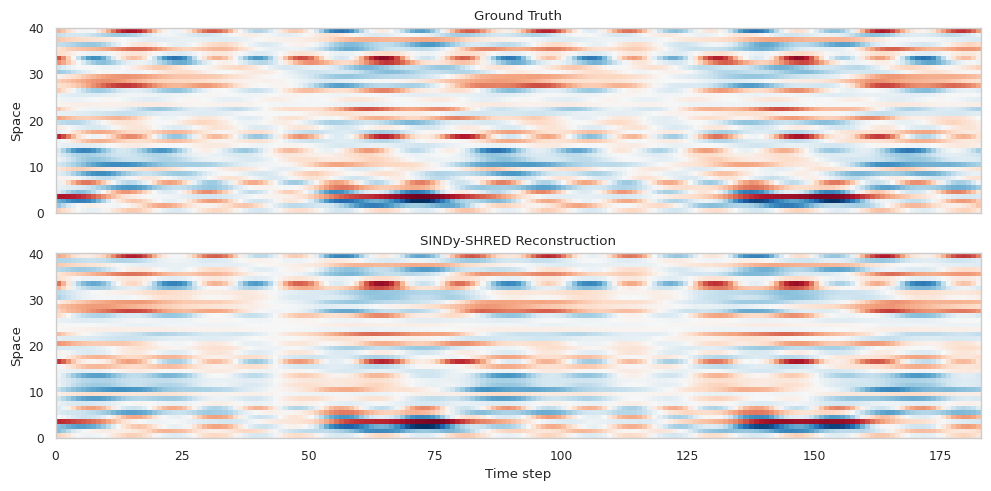

In [13]:
# Visualize reconstruction
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
ax.pcolormesh(test_ground_truth.T, **pcolor_kwargs)
ax.set_title("Ground Truth")
ax.set_ylabel("Space")

ax = axes[1]
ax.pcolormesh(test_recons.T, **pcolor_kwargs)
ax.set_title("SINDy-SHRED Reconstruction")
ax.set_ylabel("Space")
ax.set_xlabel("Time step")

fig.tight_layout()
plt.show()

## Summary

This notebook demonstrated SINDy-SHRED on synthetic multi-scale data:

1. Generated toy data from FitzHugh-Nagumo (slow) and Duffing (fast) oscillators
2. Used the `SINDyShred` class for streamlined model training
3. Discovered sparse governing equations that approximate the true dynamics
4. Achieved accurate reconstruction on held-out test data

The `SINDyShred` class simplifies the workflow compared to manual data preprocessing and model setup.